# Spam or Not Spam!!!

In this project, we will try to make a spam filter which categorizes a new message as either spam or not a spam. We will be using a real world dataset of more than 5000 messages which have already been classified by humans as spam/not-spam. We will then teach the computer how the humans classify a message and use that human knowledge to estimate probabilities for new messages — probabilities for spam and non-spam.

We will be using multinomial Naive Bayes algorithm to build the spam filter for messages.

# Reading in the dataset

In [1]:
import pandas as pd

messages = pd.read_csv(r'C:\Users\nbnav\OneDrive\Desktop\Dataquest\spamorham.txt', sep='\t', header=None,
                       names=['label', 'SMS'])

print(messages.head())
print(messages.shape)

  label                                                SMS
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
(5572, 2)


Note that 'ham' here means non-spam.

Let's see what percentage of messages are spam and what percentage of messages are non-spam. This will give us P(S) and P(H).

In [2]:
label_value_counts = messages['label'].value_counts(normalize=True) * 100
print(label_value_counts)

ham     86.593683
spam    13.406317
Name: label, dtype: float64


We can see that almost 86.6% of messages are non-spam while only 13.4% of messages are spam which makes P(H) = 0.86 and P(S) = 0.13.

# Testing the spam filter

Before creating a spam filter, it's very helpful to first think of a way of testing how well it works. When creating software (a spam filter is software), a good rule of thumb is that designing the test comes before creating the software. If we write the software first, then it's tempting to come up with a biased test just to make sure the software passes it.


Once our spam filter is done, we'll need to test how good it is with classifying new messages. To test the spam filter, we're first going to split our dataset into two categories:

* A training set, which we'll use to "train" the computer how to classify messages.
* A test set, which we'll use to test how good the spam filter is with classifying new messages.


We're going to keep 80% of our dataset for training, and 20% for testing (we want to train the algorithm on as much data as possible, but we also want to have enough test data). The dataset has 5,572 messages, which means that:

The training set will have 4,458 messages (about 80% of the dataset).

The test set will have 1,114 messages (about 20% of the dataset).

Our goal is to create a spam filter that classifies new messages with an accuracy greater than 80% — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).

# Splitting the dataset

We're going to start by randomizing the entire dataset to ensure that spam and ham messages are spread properly throughout the dataset.

In [3]:
random_data = messages.sample(frac=1, random_state=1)
print(random_data.head())

     label                                                SMS
1078   ham                       Yep, by the pretty sculpture
4028   ham      Yes, princess. Are you going to make me moan?
958    ham                         Welp apparently he retired
4642   ham                                            Havent.
4674   ham  I forgot 2 ask ü all smth.. There's a card on ...


In [4]:
random_data.reset_index(drop=True, inplace=True)

In [5]:
training_data = random_data[:4458]
test_data = random_data[4458:5572]

In [6]:
print(training_data.shape)
print(test_data.shape)

(4458, 2)
(1114, 2)


In [7]:
training_data.head()

,label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


Let's do a value count of the 'label' column again and see if it resembles the original dataset.

In [8]:
train_value_count = training_data['label'].value_counts(normalize=True) * 100
test_value_count = test_data['label'].value_counts(normalize=True) * 100
print(train_value_count)
print(test_value_count)

ham     86.54105
spam    13.45895
Name: label, dtype: float64
ham     86.804309
spam    13.195691
Name: label, dtype: float64


Both datasets, training and test, closely resembles the oriningal percentage of spam and non-spam messages and would be a good fit for our spam filter.

# Cleaning the data

Let's remove all the punctuations and make every letter lowercase.

In [9]:
import warnings
warnings.simplefilter('ignore')

training_data['SMS'] = training_data['SMS'].str.replace('\W', ' ')
training_data['SMS'] = training_data['SMS'].str.lower()

Let's check the training_data head again

In [10]:
training_data.head()

,label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


# Creating the vocabulary

Let's create a list of all the unique words there are in these messages

In [11]:
training_data['SMS'] = training_data['SMS'].str.split()

In [12]:
vocabulary = []

for sms in training_data['SMS']:
    for word in sms:
        vocabulary.append(word)

We would need to remove duplicates from the vocabulary list. One way to do it is to convert it into a set. We can convert it back into a list to continue our project.

In [13]:
print(len(vocabulary))

72427


In [14]:
vocabulary = set(vocabulary)
vocabulary = list(vocabulary)
print(len(vocabulary))

7783


We have 7783 unique words in our dataset.

To calculate all the probabilities required by the algorithm, we will need to bring the data to this format :-

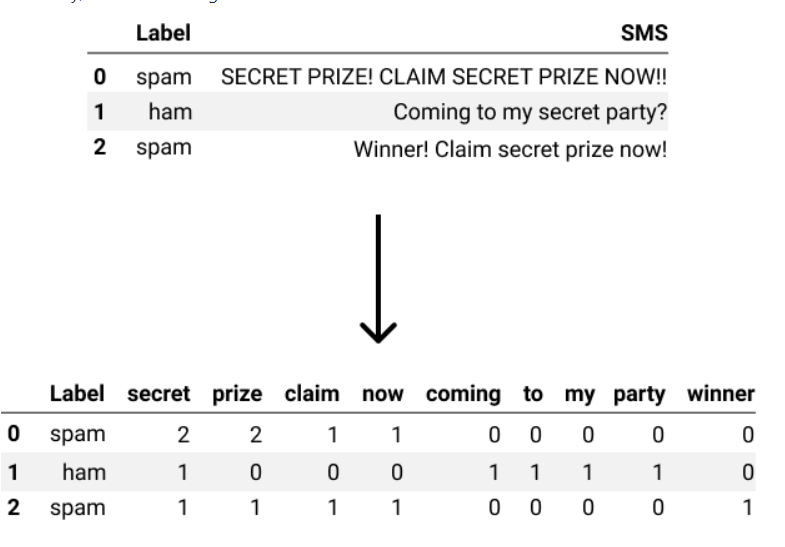

Since we have 7783 unique words in our vocabulary, we are gonna have 7783 columns in our dataset.YES 7783!!

In [15]:
word_counts_per_sms = {}
for unique_word in vocabulary:
    word_counts_per_sms[unique_word] = [0] * len(training_data['SMS'])

for index, sms in enumerate(training_data['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

Let's transform the resulting dictionary into a dataframe.

In [16]:
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,faggy,andros,infra,kit,skirt,p,deciding,wavering,sisters,ba,...,failed,hyde,exeter,wrong,president,useful,upto,pissed,m95,goin2bed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As expected we have 7783 columns in our dataset. Now let's join this dataset with our training dataset with has the label column.

In [17]:
training_data_clean = pd.concat([training_data, word_counts], axis=1)
training_data_clean.head()

,label,SMS,faggy,andros,infra,kit,skirt,p,deciding,wavering,...,failed,hyde,exeter,wrong,president,useful,upto,pissed,m95,goin2bed
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We got what we need, we can now start calculating probabilities.

The Naive Bayes algorithm will need to answer these two probability questions-

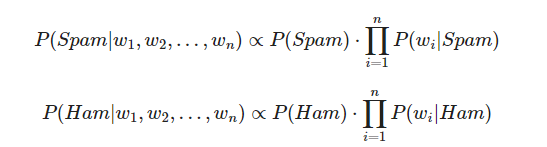

The formula formulates this way due to the assumption of conditional independence. Now to compute this formula, the algorithm would need to calculate these formulas - 

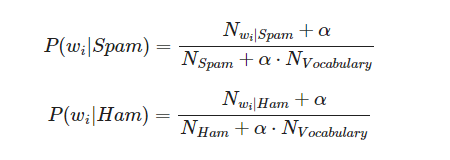

# Calculating the constants

Since some variables will be same throughout our calculations, it makes sense to calculate them first so the computer would not need to calculate them again and again. These variables are - 

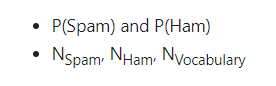

We will also be using laplace smoothing and set alpha = 1.

In [18]:
# isolating the spam and non-spam messages
spam_messages = training_data_clean[training_data_clean['label'] == 'spam']
ham_messages = training_data_clean[training_data_clean['label'] == 'ham']

# calculating P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(training_data_clean)
p_ham = len(ham_messages) / len(training_data_clean)

# calculating N_Spam
n_spam_len = spam_messages['SMS'].apply(len)
n_spam = n_spam_len.sum()

# calculating N_ham
n_ham_len = ham_messages['SMS'].apply(len)
n_ham = n_ham_len.sum()

# calculating N_Vocabualry
n_vocabulary = len(vocabulary)

# define alpha
alpha = 1


# Calculating parameters

Now that we have calculated the constants, lets calculate P(Wi|Spam) and P(Wi|Ham) for every word in our vocabulary!!

In [19]:
parameters_spam = {unique_word: 0 for unique_word in vocabulary}
parameters_ham = {unique_word: 0 for unique_word in vocabulary}

# Calculate parameters
for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum()   # spam_messages already defined in a cell above
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + (alpha * n_vocabulary))
    parameters_spam[word] = p_word_given_spam

    n_word_given_ham = ham_messages[word].sum()   # ham_messages already defined in a cell above
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + (alpha * n_vocabulary))
    parameters_ham[word] = p_word_given_ham

# Classifying a new message

Now that we have all our parameters calculated, we can start creating the spam filter. The spam filter can be understood as a function that:

Takes in as input a new message (w1, w2, ..., wn).
Calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn).
Compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn), and:
* If P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn), then the message is classified as ham.
* If P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn), then the message is classified as spam.
* If P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn), then the algorithm may request human help.

In [20]:
import re

def classify(message):
    '''
    message: a string
    '''
    
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
            
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)
    
    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

# Testing with custom messages

Let's test our newly built spam filter with some custom messages!!

In [21]:
classify('You have won 6 million dollars!!. Click to claim now.')

P(Spam|message): 3.9559552020833925e-31
P(Ham|message): 1.4809362548585278e-33
Label: Spam


In [22]:
classify('i will meet you there at 6 pm be ready')

P(Spam|message): 5.952479623822477e-32
P(Ham|message): 6.4709453143226e-27
Label: Ham


Seems like our spam filter is working good on our custom messages. Now let's test it on our test data set which we set aside before which had 1114 messages.

# Measuring the spam filter's accuracy

Let's tweak our original function 'classify' a bit so that it only returns a string 'spam' or 'ham'. We will then make a new column in our test_data that has the result of the functions classification.

In [23]:
def classify_test(message):
    '''
    message: a string
    '''
    
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
    
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'equal probabilities'

In [24]:
test_data['predicted'] = test_data['SMS'].apply(classify_test)

In [25]:
test_data.head()

,label,SMS,predicted
4458,ham,Later i guess. I needa do mcat study too.,ham
4459,ham,But i haf enuff space got like 4 mb...,ham
4460,spam,Had your mobile 10 mths? Update to latest Oran...,spam
4461,ham,All sounds good. Fingers . Makes it difficult ...,ham
4462,ham,"All done, all handed in. Don't know if mega sh...",ham


Now let's see in how many rows did we get label = predicted

In [26]:
correct = 0
total = test_data.shape[0]

for row in test_data.iterrows():
    row = row[1]
    if row['label'] == row['predicted']:
        correct += 1

In [28]:
print('Total correct predictions:', correct)
print('Incorrect predictions:', total - correct)
print('Accuracy:', correct/ total)

Total correct predictions: 1100
Incorrect predictions: 14
Accuracy: 0.9874326750448833


We got 98.74% of our messages correctly labeled by the sapm filter. This is more than our target of 80%. Let's check the 14 messages which got incorrectly labeled and see why could that have happened.

In [40]:
incorrect_predictions = pd.DataFrame(columns=test_data.columns)

for row in test_data.iterrows():
    row = row[1]
    if row['label'] != row['predicted']:
        incorrect_predictions = incorrect_predictions.append(row)

In [48]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
print(incorrect_predictions['SMS'])

4572                                                                                                                                                                                                                                                                                                         Not heard from U4 a while. Call me now am here all night with just my knickers on. Make me beg for it like U did last time 01223585236 XX Luv Nikiyu4.net
4593                                                                                                                                                                                                                                                                                                   More people are dogging in your area now. Call 09090204448 and join like minded guys. Why not arrange 1 yourself. There's 1 this evening. A£1.50 minAPN LS278BB
4610                                                                                      

Looks like some spam messages were written in a very human like conversation that the algorithm classified them as non-spam. The issue could be fixed with a bigger learning data for the algorithm and making a more complex version of it. For example taking in case-senstivity and punctuations into account.